# Exploratory data analysis

### EDA on payment_default data set

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.spatial.distance import cdist
import warnings
from matplotlib.ticker import MaxNLocator
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

In [2]:

# Load the data
default_df = pd.read_csv("data/payment_default.csv")
history_df = pd.read_csv("data/payment_history.csv")

default_df = default_df.sort_values(by='client_id').reset_index(drop=True)
history_df = history_df.sort_values(by=['client_id', 'month']).reset_index(drop=True)

# display the first few rows after sorting
print(default_df.head())
print(history_df.head())

   client_id  credit_given  gender  education  marital_status  month  default
0          1         20000       2          2               1     10        1
1          2        120000       2          2               2     10        1
2          4         50000       2          2               1     10        0
3          7        500000       1          1               2     10        0
4          9        140000       2          3               1     10        0
   client_id  payment_status  bill_amt  paid_amt  month
0          1              -2         0         0      3
1          1              -2         0         0      4
2          1              -1         0         0      5
3          1              -1       689         0      6
4          1               2      3102       689      7


In [3]:
# Check for missing values
print("Missing Values in payment_default:\n", default_df.isnull().sum())
print("Missing Values in payment_history:\n", history_df.isnull().sum())


Missing Values in payment_default:
 client_id         0
credit_given      0
gender            0
education         0
marital_status    0
month             0
default           0
dtype: int64
Missing Values in payment_history:
 client_id         0
payment_status    0
bill_amt          0
paid_amt          0
month             0
dtype: int64


In [4]:
# Checking number of rows
print(default_df.shape[0])
print(history_df.shape[0])

21455
132000


In [5]:
print(default_df.duplicated().sum())
print(history_df.duplicated().sum())

0
0


In [6]:
#missing data in default
total = default_df.isnull().sum().sort_values(ascending=False)
percent = (default_df.isnull().sum()/default_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
client_id,0,0.0
credit_given,0,0.0
gender,0,0.0
education,0,0.0
marital_status,0,0.0
month,0,0.0
default,0,0.0


In [7]:
#missing data in history
total = history_df.isnull().sum().sort_values(ascending=False)
percent = (history_df.isnull().sum()/history_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
client_id,0,0.0
payment_status,0,0.0
bill_amt,0,0.0
paid_amt,0,0.0
month,0,0.0


In [8]:
# checking the shape of the data
print("Defaults:", default_df.shape)
print(default_df.head(), "\n")
print("History:", history_df.shape)
print(history_df.head())

Defaults: (21455, 7)
   client_id  credit_given  gender  education  marital_status  month  default
0          1         20000       2          2               1     10        1
1          2        120000       2          2               2     10        1
2          4         50000       2          2               1     10        0
3          7        500000       1          1               2     10        0
4          9        140000       2          3               1     10        0 

History: (132000, 5)
   client_id  payment_status  bill_amt  paid_amt  month
0          1              -2         0         0      3
1          1              -2         0         0      4
2          1              -1         0         0      5
3          1              -1       689         0      6
4          1               2      3102       689      7


In [9]:
# ## 3) Quick Checks & Cleaning
# 3a) Check unique months
print("Default months:", default_df.month.unique())
print("History months:", sorted(history_df.month.unique()))

# 3b) Payment_status distribution (including -2)
print(history_df.payment_status.value_counts(dropna=False))

# 3c) Bill/paid negatives
print("Negative bills:", (history_df.bill_amt < 0).sum(),
      "Negative paid:", (history_df.paid_amt < 0).sum())

# we have the unwanted status as -2, with the large amount if we drop,
# our model will be biased towards the paid status

Default months: [10]
History months: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
payment_status
 0    70063
-1    25522
-2    18076
 2    13907
 1     2718
 3     1060
 4      331
 7      152
 5       95
 6       55
 8       21
Name: count, dtype: int64
Negative bills: 2878 Negative paid: 0


In [10]:
print("=== payment_default.csv unique values ===")
for col in default_df.columns:
    uniques = default_df[col].unique()
    print(f"{col!r} ({len(uniques)}): {uniques[:10]}{'...' if len(uniques)>10 else ''}")

=== payment_default.csv unique values ===
'client_id' (21455): [ 1  2  4  7  9 10 11 12 14 16]...
'credit_given' (81): [ 20000 120000  50000 500000 140000 200000 260000  70000 320000 180000]...
'gender' (2): [2 1]
'education' (7): [2 1 3 5 4 6 0]
'marital_status' (4): [1 2 3 0]
'month' (1): [10]
'default' (2): [1 0]


In [11]:
# 1) Total number of unique clients in payment default
num_unique_clients = default_df['client_id'].nunique()
print(f"Number of unique clients in default_df: {num_unique_clients}")


Number of unique clients in default_df: 21455


In [12]:
month_counts = default_df['month'].value_counts()
print("\n=== month counts ===")
print(month_counts)


=== month counts ===
month
10    21455
Name: count, dtype: int64


In [13]:
# lets get the count baseed on the marital status
marital_status_counts = default_df['marital_status'].value_counts()
print("\n=== marital_status counts ===")
print(marital_status_counts)


=== marital_status counts ===
marital_status
2    11443
1     9739
3      230
0       43
Name: count, dtype: int64


In [14]:
# 1) Define a mapping from codes → labels based on the assumptions
marital_map = {
    1: "Single",
    2: "Married",
    3: "Divorced",
    0: "Unknown"
}

# 2) Create a new categorical column
default_df["marital_status_cat"] = default_df["marital_status"].map(marital_map)

# 3) Check the new value counts
print("=== marital_status categories ===")
print(default_df["marital_status_cat"].value_counts())


=== marital_status categories ===
marital_status_cat
Married     11443
Single       9739
Divorced      230
Unknown        43
Name: count, dtype: int64


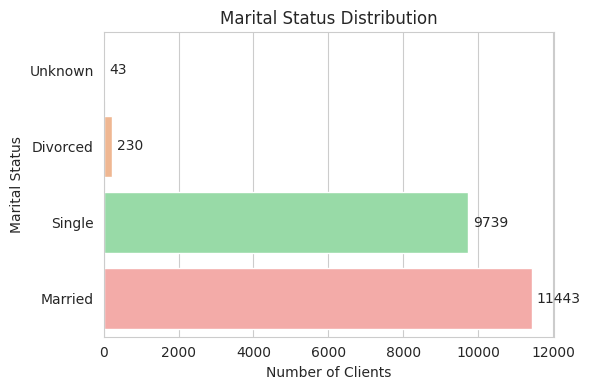

In [15]:
# 1) Compute counts
counts = default_df["marital_status_cat"].value_counts().sort_values(ascending=True)

# 2) Plot horizontal bar chart
plt.figure(figsize=(6,4))
sns.barplot(x=counts.values, y=counts.index, palette="pastel")
plt.title("Marital Status Distribution")
plt.xlabel("Number of Clients")
plt.ylabel("Marital Status")

# 3) Annotate each bar with the count
for i, (value, name) in enumerate(zip(counts.values, counts.index)):
    plt.text(value + counts.max()*0.01, i, str(value), va='center')

plt.tight_layout()
plt.show()

In [16]:
# count of default and non default
default_counts = default_df['default'].value_counts()
print("default and non default counts:")
print(default_counts)

default and non default counts:
default
0    16663
1     4792
Name: count, dtype: int64


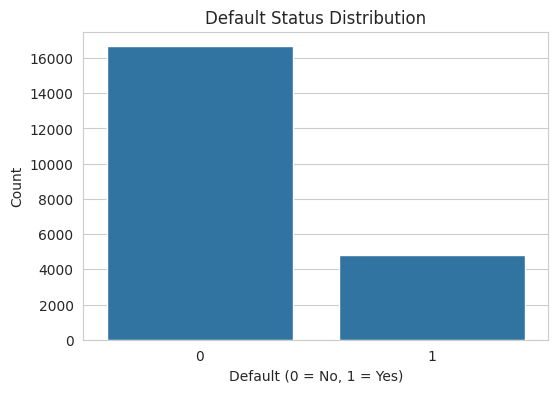

In [17]:
# 4) Default vs Non-Default Distribution
plt.figure()
sns.countplot(x="default", data=default_df)
plt.title("Default Status Distribution")
plt.xlabel("Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

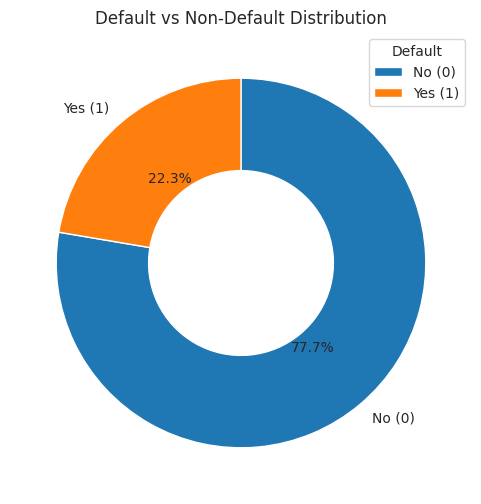

In [18]:
plt.figure(figsize=(6,6))
default_counts.plot.pie(
    labels= ['No (0)', 'Yes (1)'],
    autopct="%.1f%%",      # show percentages
    startangle=90,         # rotate for aesthetic
    counterclock=False,
    wedgeprops=dict(width=0.5)  # donut style (optional)
)
plt.title("Default vs Non-Default Distribution")
plt.ylabel("")             # hide y-label
plt.legend(title="Default", loc="best")
plt.show()

In [19]:
# 1) Define the mapping
gender_map = {2: "Male", 1: "Female"}

# 2) Create a new column with labels
default_df["gender_label"] = default_df["gender"].map(gender_map)

# 3) Check counts by label
print(default_df["gender_label"].value_counts())



gender_label
Male      12960
Female     8495
Name: count, dtype: int64


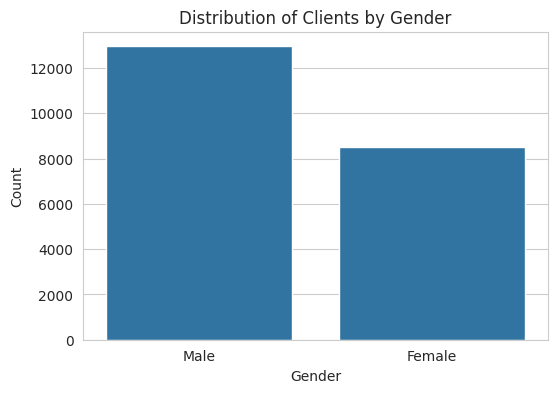

In [20]:
# Distribution of Clients by Gender
plt.figure(figsize=(6,4))
sns.countplot(x="gender_label", data=default_df, order=["Male","Female"])
plt.title("Distribution of Clients by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

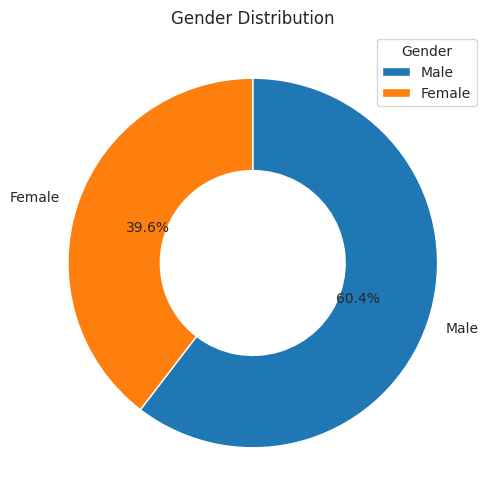

In [21]:
# B) Pie chart with labels
plt.figure(figsize=(6,6))
default_df["gender_label"].value_counts().plot.pie(
    autopct="%.1f%%",
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.5)
)
plt.title("Gender Distribution")
plt.ylabel("")
plt.legend(title="Gender", loc="best")
plt.show()

In [22]:
# 2) Count of defaults vs non-defaults within each gender
gender_default_counts = pd.crosstab(
    default_df['gender_label'],
    default_df['default'],
    rownames=['gender_label'],
    colnames=['default']
)
print("\nDefault counts by gender (columns: 0 = non-default, 1 = default):")
print(gender_default_counts)


Default counts by gender (columns: 0 = non-default, 1 = default):
default           0     1
gender_label             
Female         6407  2088
Male          10256  2704


In [23]:
# Percent default rate by gender
gender_default_rate = (
    gender_default_counts[1] / gender_default_counts.sum(axis=1)
).rename("default_rate")
print("\nDefault rate by gender:")
print(gender_default_rate)



Default rate by gender:
gender_label
Female    0.245792
Male      0.208642
Name: default_rate, dtype: float64


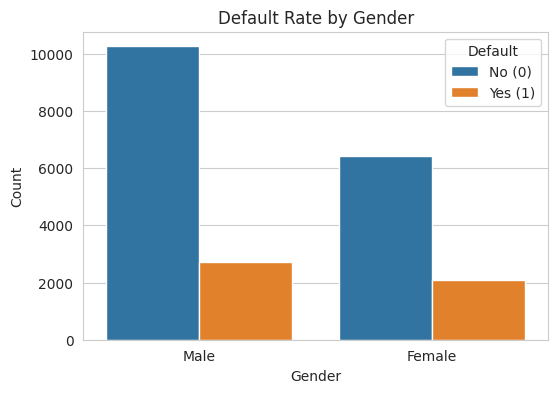

In [24]:
# 5) Combined: Default by Gender
plt.figure()
sns.countplot(x="gender_label", hue="default", data=default_df)
plt.title("Default Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Default", labels=["No (0)", "Yes (1)"])
plt.show()


In [25]:
# 4) Crosstab: gender counts within each marital status
gender_by_marital = pd.crosstab(
    default_df["marital_status_cat"],
    default_df["gender_label"],
    rownames=["Marital Status "],
    colnames=["Gender"]
)
print("\n=== Gender counts by marital status ===")
print(gender_by_marital)



=== Gender counts by marital status ===
Gender           Female  Male
Marital Status               
Divorced             93   137
Married            4676  6767
Single             3714  6025
Unknown              12    31


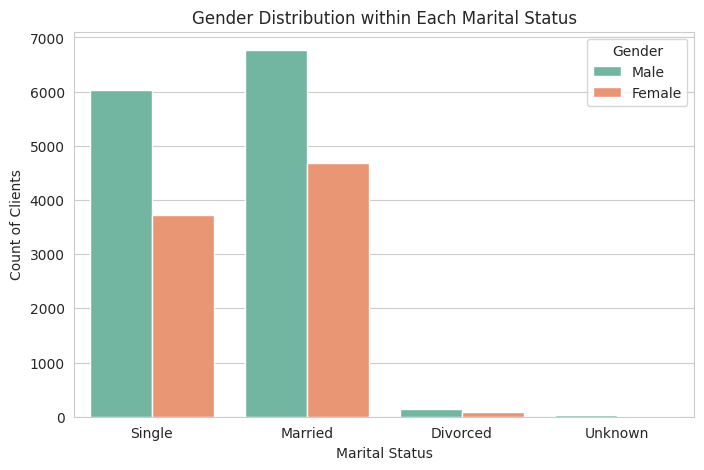

In [26]:
# 5) Visualize with Seaborn
plt.figure(figsize=(8,5))
sns.countplot(
    x="marital_status_cat",
    hue="gender_label",
    data=default_df,
    palette="Set2"
)
plt.title("Gender Distribution within Each Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count of Clients")
plt.legend(title="Gender", labels=["Male","Female"])
plt.show()


Text(0.5, 0.98, 'Default Distribution by Marital Status Separately for Each Gender')

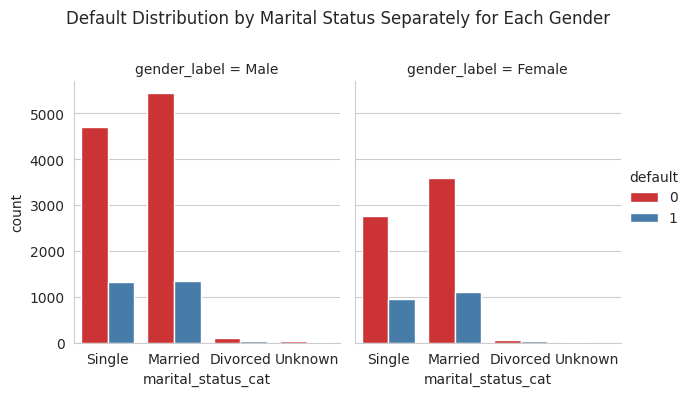

In [27]:
# 6) Combined: Default by Marital Status, Faceted by Gender
sns.catplot(
    x="marital_status_cat",
    hue="default",
    col="gender_label",
    data=default_df,
    kind="count",
    palette="Set1",
    height=4,
    aspect=0.8
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Default Distribution by Marital Status Separately for Each Gender")


### EDA on payment_history dataset

In [61]:
print("=== payment_history.csv unique values ===")
for col in history_df.columns:
    uniques = history_df[col].unique()
    print(f"{col!r} ({len(uniques)}): {uniques[:10]}{'...' if len(uniques)>10 else ''}")

=== payment_history.csv unique values ===
'client_id' (22000): [ 1  2  4  7  9 10 11 12 14 16]...
'payment_status' (11): [-2 -1  2  0  1  3  6  5  4  7]...
'bill_amt' (65957): [    0   689  3102  3913  3261  3455  3272  2682  1725 29547]...
'paid_amt' (16365): [    0   689  2000  1000  1069  1100  1200  2019 13770 13750]...
'month' (6): [3 4 5 6 7 8]
'payment_status_imputed_similar' (10): [-1  2  0  1  3  8  6  5  4  7]
'payment_status_imputed_clientmean' (10): [ 0 -1  2  1  3  6  5  4  7  8]


In [62]:
# 1) Total number of unique clients
num_unique_clients = history_df['client_id'].nunique()
print(f"Number of unique clients in history_df: {num_unique_clients}")


Number of unique clients in history_df: 22000


In [63]:
# payment status counts
payment_status_count = history_df['payment_status'].value_counts()
print("\n=== payment_status counts ===")
print(payment_status_count)


=== payment_status counts ===
payment_status
 0    70063
-1    25522
-2    18076
 2    13907
 1     2718
 3     1060
 4      331
 7      152
 5       95
 6       55
 8       21
Name: count, dtype: int64


In [64]:
# month wise history counts
month_counts = history_df['month'].value_counts()
print("\n=== month counts ===")
print(month_counts)


=== month counts ===
month
3    22000
4    22000
5    22000
6    22000
7    22000
8    22000
Name: count, dtype: int64


In [65]:
# Copying to be safe
history_df = history_df.copy()

# =========================================================
# 1) Impute -2 using overall (bill_amt, paid_amt) similarity
# =========================================================
# 1.1 Compute centroids for all statuses excluding -2

valid = history_df[history_df['payment_status'] != -2]
centroids = valid.groupby('payment_status')[['bill_amt', 'paid_amt']].mean()

# 1.2 Assign nearest payment_status
def assign_nearest_status(row, centroids):
    if row['payment_status'] != -2:
        return row['payment_status']
    point = np.array([[row['bill_amt'], row['paid_amt']]])
    dists = cdist(point, centroids.values, metric='euclidean').ravel()
    return centroids.index[dists.argmin()]

# 1.3 Store in a new column
history_df['payment_status_imputed_similar'] = history_df.apply(assign_nearest_status, axis=1, args=(centroids,))
print(history_df["payment_status"].value_counts())
print(history_df["payment_status_imputed_similar"].value_counts())



payment_status
 0    70063
-1    25522
-2    18076
 2    13907
 1     2718
 3     1060
 4      331
 7      152
 5       95
 6       55
 8       21
Name: count, dtype: int64
payment_status_imputed_similar
 0    70133
-1    42646
 2    14021
 1     2958
 3     1129
 7      392
 4      347
 8      199
 5      104
 6       71
Name: count, dtype: int64


In [66]:
# Group by month and payment_status, then count occurrences
status_monthly_counts = history_df.groupby(["month", "payment_status_imputed_similar"]).size().unstack(fill_value=0)

# Display the result
print("=== Payment Status Counts by Month using payment_status_imputed_similar===")
print(status_monthly_counts)


=== Payment Status Counts by Month using payment_status_imputed_similar===
payment_status_imputed_similar    -1      0     1     2    3   4   5   6   7  \
month                                                                          
3                               7732  11873    34  2067  132  42  10  21  71   
4                               7323  12389    37  1936  142  62  16   6  70   
5                               7274  12040    37  2313  153  49  21  10  79   
6                               7251  11529    44  2801  188  60  14  16  56   
7                               7052  11513    72  2904  264  73  19   8  59   
8                               6014  10789  2734  2000  250  61  24  10  57   

payment_status_imputed_similar   8  
month                               
3                               18  
4                               19  
5                               24  
6                               41  
7                               36  
8                        

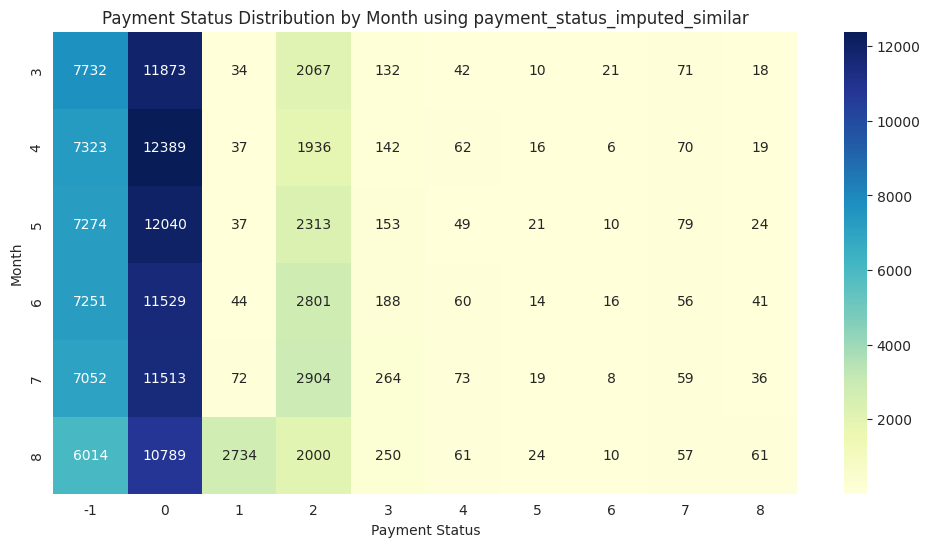

In [67]:
plt.figure(figsize=(12, 6))
sns.heatmap(status_monthly_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Payment Status Distribution by Month using payment_status_imputed_similar")
plt.xlabel("Payment Status")
plt.ylabel("Month")
plt.show()

In [69]:

# =========================================================
# 2) Client-wise mean imputation for -2
# =========================================================

def impute_clientwise_mean(group):
    non_neg2 = group[group["payment_status"] != -2]["payment_status"]
    if not non_neg2.empty:
        mean_status = round(non_neg2.mean())
        group.loc[group["payment_status"] == -2, "payment_status_imputed_clientmean"] = mean_status
    else:
        group.loc[group["payment_status"] == -2, "payment_status_imputed_clientmean"] = 0
    return group

# Create column and fill default values to start
history_df["payment_status_imputed_clientmean"] = history_df["payment_status"]

# Apply group-wise imputation
history_df = history_df.groupby("client_id").apply(impute_clientwise_mean).reset_index(drop=True)

print(history_df["payment_status"].value_counts())
print(history_df["payment_status_imputed_clientmean"].value_counts()) 

payment_status
 0    70063
-1    25522
-2    18076
 2    13907
 1     2718
 3     1060
 4      331
 7      152
 5       95
 6       55
 8       21
Name: count, dtype: int64
payment_status_imputed_clientmean
 0    82612
-1    28047
 2    14134
 1     5492
 3     1061
 4      331
 7      152
 5       95
 6       55
 8       21
Name: count, dtype: int64


In [ ]:
# Group by month and payment_status, then count occurrences
status_monthly_counts = history_df.groupby(["month", "payment_status_imputed_clientmean"]).size().unstack(fill_value=0)

# Display the result
print("=== Payment Status Counts by Month using payment_status_imputed_clientmean===")
print(status_monthly_counts)


=== Payment Status Counts by Month using payment_status_imputed_clientmean===
payment_status_imputed_clientmean    -1      0     1     2    3   4   5   6  \
month                                                                         
3                                  4773  14280   594  2128  125  40  10  16   
4                                  4617  14590   563  1979  132  57  15   4   
5                                  4673  14162   554  2356  139  47  20   5   
6                                  4814  13556   533  2815  175  58  13  14   
7                                  4693  13514   551  2884  249  73  16   7   
8                                  4477  12510  2697  1972  241  56  21   9   

payment_status_imputed_clientmean   7   8  
month                                      
3                                  32   2  
4                                  42   1  
5                                  42   2  
6                                  19   3  
7                        

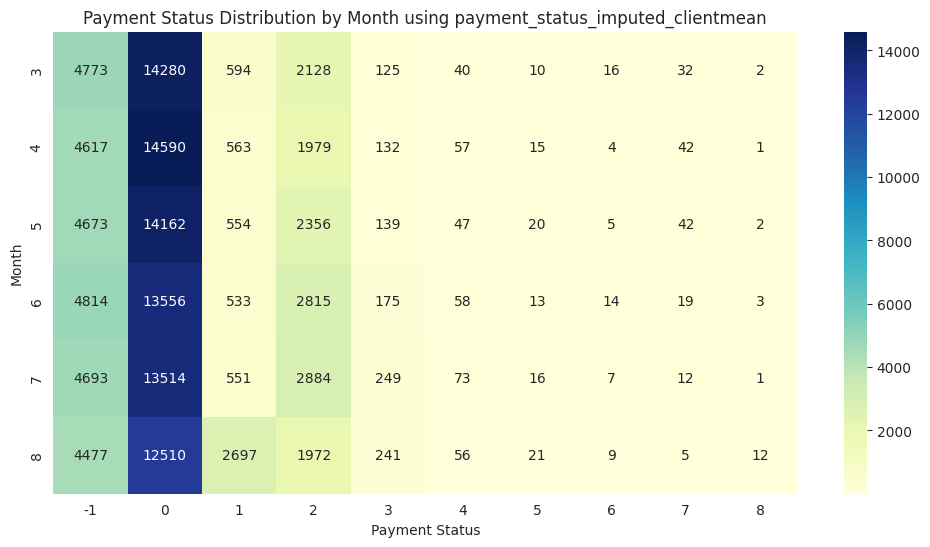

In [ ]:
#Payment Status Distribution by Month using payment_status_imputed_clientmean
plt.figure(figsize=(12, 6))
sns.heatmap(status_monthly_counts, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Payment Status Distribution by Month using payment_status_imputed_clientmean")
plt.xlabel("Payment Status")
plt.ylabel("Month")
plt.show()


In [ ]:
# month wise trend and status summary
def month_wise_status_summary_with_counts(history_df):
    df = history_df.copy()
    df["status"] = df["payment_status_imputed_similar"]

    summary = df.groupby("month").apply(lambda g: pd.Series({
        "total_clients": g["client_id"].nunique(),
        "on_time_count": (g["status"] == 0).sum(),
        "late_count": (g["status"] > 0).sum(),
        "early_count": (g["status"] < 0).sum(),
        "on_time_pct": (g["status"] == 0).mean(),
        "late_pct": (g["status"] > 0).mean(),
        "early_pct": (g["status"] < 0).mean(),
        "avg_delay": g["status"].mean()
    })).reset_index()

    return summary


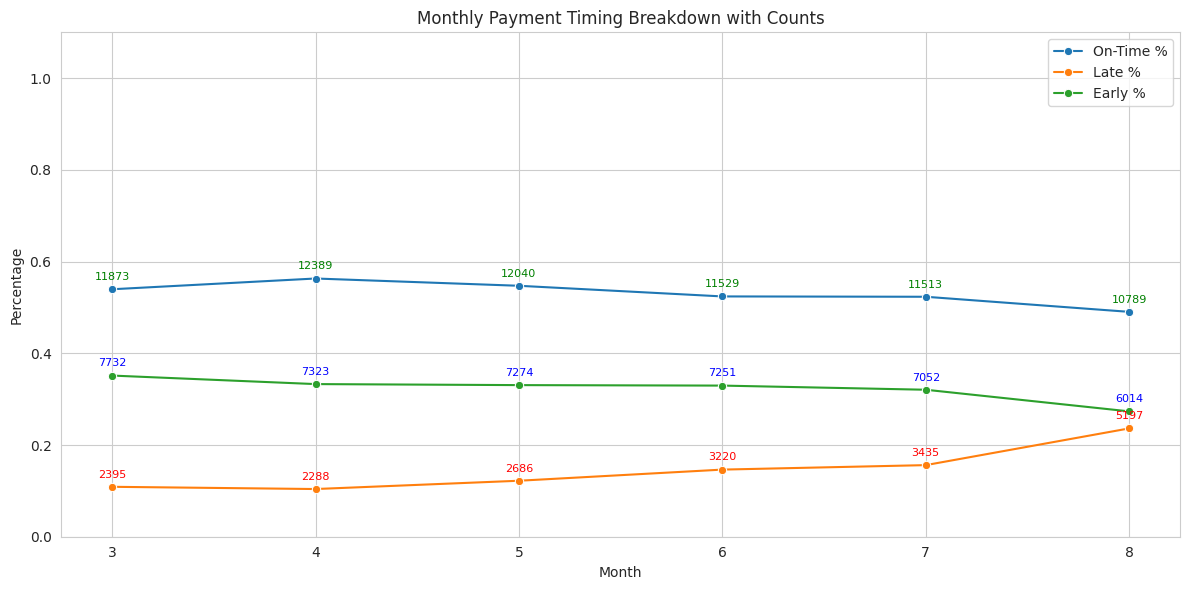

In [ ]:
summary_df = month_wise_status_summary_with_counts(history_df)

plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='on_time_pct', data=summary_df, label='On-Time %', marker='o')
sns.lineplot(x='month', y='late_pct', data=summary_df, label='Late %', marker='o')
sns.lineplot(x='month', y='early_pct', data=summary_df, label='Early %', marker='o')

# Annotate counts on each line
for i, row in summary_df.iterrows():
    plt.text(row['month'], row['on_time_pct'] + 0.02, f"{int(row['on_time_count'])}", ha='center', fontsize=8, color='green')
    plt.text(row['month'], row['late_pct'] + 0.02, f"{int(row['late_count'])}", ha='center', fontsize=8, color='red')
    plt.text(row['month'], row['early_pct'] + 0.02, f"{int(row['early_count'])}", ha='center', fontsize=8, color='blue')

plt.title("Monthly Payment Timing Breakdown with Counts")
plt.ylabel("Percentage")
plt.xlabel("Month")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# getting data of the particular client

def plot_client_history(history_df, client_id):
    """
    For a given client_id, shows:
      • Left subplot: payment_status (delay code) over time with integer y-axis
      • Right subplot: bill_amt vs paid_amt as side-by-side bars
    """
    df = history_df[history_df.client_id == client_id].sort_values("month")
    if df.empty:
        print(f"No history for client {client_id}")
        return

    months = df['month'].astype(int).tolist()
    x = np.arange(len(months))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

    # ─── 1) Payment Status ─────────────────────────────────────────────
    ax = axes[0]
    ax.plot(months, df['payment_status_imputed_similar'], marker='o', linestyle='-')
    ax.set_title("Payment Status (Delay Code)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Delay Code")
    ax.set_xticks(months)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # <-- Force integer y-axis

    # ─── 2) Bill vs Paid Amounts ───────────────────────────────────────
    ax = axes[1]
    width = 0.35
    ax.bar(x - width/2, df['bill_amt'], width, label='Bill Amt')
    ax.bar(x + width/2, df['paid_amt'], width, label='Paid Amt')
    ax.set_title("Bill vs Paid Amount")
    ax.set_xlabel("Month")
    ax.set_ylabel("Amount")
    ax.set_xticks(x)
    ax.set_xticklabels(months)
    ax.legend()

    plt.suptitle(f"Client {client_id} Payment History", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

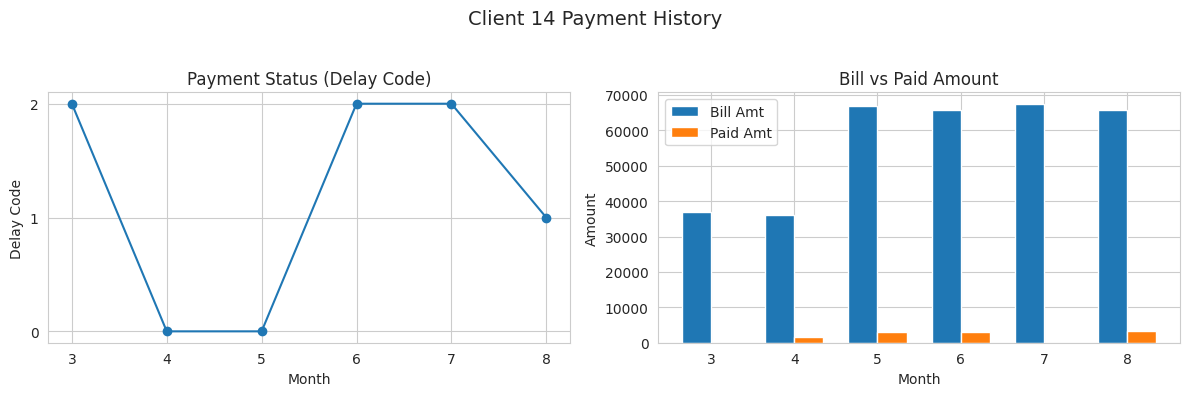

In [ ]:
plot_client_history(history_df, client_id=14)
# change the desired client_id

In [ ]:
# 3) Aggregate History into Per-Client Features
def aggregate_history(history_df, default_df):
    df = history_df.merge(default_df[['client_id','credit_given']], on='client_id', how='left')
    df['utilization'] = df['bill_amt'] / (df['credit_given'] + 1e-6)
    
    def trend(g):
        if len(g) < 2: return 0
        return np.polyfit(g.month, g.payment_status_imputed_similar, 1)[0]
    
    feats = df.groupby('client_id').apply(lambda g: pd.Series({
        'hist_count': g.shape[0],
        'late_count': (g.payment_status_imputed_similar > 0).sum(),
        'on_time_count': (g.payment_status_imputed_similar == 0).sum(),
        'avg_delay': g.payment_status_imputed_similar.mean(),
        'max_delay': g.payment_status_imputed_similar.max(),
        'delay_ratio': (g.payment_status_imputed_similar > 0).mean(),
        'bill_sum': g.bill_amt.sum(),
        'paid_sum': g.paid_amt.sum(),
        'payment_ratio_mean': (g.paid_amt/(g.bill_amt+1)).mean(),
        'utilization_mean': g.utilization.mean(),
        'delay_trend': trend(g)
    })).reset_index()
    return feats

features_df = aggregate_history(history_df, default_df)


In [ ]:
# import pandas as pd
# import numpy as np

# def aggregate_history(history_df, default_df):
#     # 1) Merge in credit_given
#     df = history_df.merge(
#         default_df[['client_id', 'credit_given']], 
#         on='client_id', how='left'
#     ).copy()

#     # 2) Compute utilization
#     df['utilization'] = df['bill_amt'] / (df['credit_given'] + 1e-6)

#     # 3) Define a per-client feature calculator
#     def calc_feats(g):
#         status = g['payment_status_imputed_similar']
#         bills   = g['bill_amt']
#         pays    = g['paid_amt']

#         return pd.Series({
#             'hist_count':           len(g),
#             'late_count':           (status > 0).sum(),
#             'on_time_count':        (status == 0).sum(),
#             'avg_delay':            status.mean(),
#             'max_delay':            status.max(),
#             'delay_ratio':          (status > 0).mean(),
#             'pct_on_time':          (status == 0).mean(),
#             'bill_sum':             bills.sum(),
#             'paid_sum':             pays.sum(),
#             'bill_mean':            bills.mean(),
#             'paid_mean':            pays.mean(),
#             'zero_bill_count':      (bills == 0).sum(),
#             'zero_payment_count':   (pays == 0).sum(),
#             'payment_ratio_mean':   (pays / (bills + 1)).mean(),
#             'payment_ratio_min':    (pays / (bills + 1)).min(),
#             'overpayment_count':    (pays > bills).sum(),
#             'utilization_mean':     g['utilization'].mean(),
#             'utilization_max':      g['utilization'].max(),
#             'delay_trend':          np.polyfit(g['month'], status, 1)[0] 
#         })

#     # 4) Apply per-client
#     feats = df.groupby('client_id').apply(calc_feats).reset_index()
#     return feats

# # Usage
# features_df = aggregate_history(history_df, default_df)


In [ ]:
features_df.head()

,client_id,hist_count,late_count,on_time_count,avg_delay,max_delay,delay_ratio,bill_sum,paid_sum,payment_ratio_mean,utilization_mean,delay_trend
0,1,6.0,2.0,0.0,0.000000,2.0,0.333333,7704.0,689.0,0.037007,0.064200,0.685714
1,2,6.0,2.0,3.0,0.500000,2.0,0.333333,17077.0,5000.0,0.311790,0.023718,-0.257143
2,4,6.0,0.0,6.0,0.000000,0.0,0.000000,231334.0,8388.0,0.036395,0.771113,0.000000
3,7,6.0,0.0,6.0,0.000000,0.0,0.000000,2724595.0,180759.0,0.071127,0.908198,0.000000
4,9,6.0,1.0,5.0,0.333333,2.0,0.166667,65212.0,6761.0,0.127689,0.077633,0.057143


In [ ]:
default_df.head()

,client_id,credit_given,gender,education,marital_status,month,default,marital_status_cat,gender_label
0,1,20000,2,2,1,10,1,Single,Male
1,2,120000,2,2,2,10,1,Married,Male
2,4,50000,2,2,1,10,0,Single,Male
3,7,500000,1,1,2,10,0,Married,Female
4,9,140000,2,3,1,10,0,Single,Male


In [ ]:
combined_df = default_df.merge(
    features_df,
    on='client_id',
    how='left'
).fillna(0)

print("Combined shape:", combined_df.shape)
combined_df.head()

Combined shape: (21455, 20)


,client_id,credit_given,gender,education,marital_status,month,default,marital_status_cat,gender_label,hist_count,late_count,on_time_count,avg_delay,max_delay,delay_ratio,bill_sum,paid_sum,payment_ratio_mean,utilization_mean,delay_trend
0,1,20000,2,2,1,10,1,Single,Male,6.0,2.0,0.0,0.000000,2.0,0.333333,7704.0,689.0,0.037007,0.064200,0.685714
1,2,120000,2,2,2,10,1,Married,Male,6.0,2.0,3.0,0.500000,2.0,0.333333,17077.0,5000.0,0.311790,0.023718,-0.257143
2,4,50000,2,2,1,10,0,Single,Male,6.0,0.0,6.0,0.000000,0.0,0.000000,231334.0,8388.0,0.036395,0.771113,0.000000
3,7,500000,1,1,2,10,0,Married,Female,6.0,0.0,6.0,0.000000,0.0,0.000000,2724595.0,180759.0,0.071127,0.908198,0.000000
4,9,140000,2,3,1,10,0,Single,Male,6.0,1.0,5.0,0.333333,2.0,0.166667,65212.0,6761.0,0.127689,0.077633,0.057143


In [ ]:
#  Identify client_ids in features_df but not in default_df
default_ids = set(default_df['client_id'])
feature_ids = set(features_df['client_id'])
history_only_ids = feature_ids - default_ids

#  Build a separate DataFrame for them
history_only_df = features_df[features_df['client_id'].isin(history_only_ids)].copy()

print("History-only features shape:", history_only_df.shape)


History-only features shape: (545, 12)


In [ ]:
history_only_df = (
    features_df
    .merge(default_df[['client_id']], on='client_id', how='left', indicator=True)
    .query("_merge == 'left_only'")
    .drop(columns=['_merge'])
)

print("History-only features shape:", history_only_df.shape)
history_only_df.head()

History-only features shape: (545, 12)


,client_id,hist_count,late_count,on_time_count,avg_delay,max_delay,delay_ratio,bill_sum,paid_sum,payment_ratio_mean,utilization_mean,delay_trend
62,85,6.0,0.0,6.0,0.000000,0.0,0.000000,177499.0,6052.0,0.035762,NaN,0.000000
168,222,6.0,0.0,6.0,0.000000,0.0,0.000000,2005418.0,73223.0,0.036510,NaN,0.000000
209,281,6.0,0.0,4.0,-0.333333,0.0,0.000000,6448.0,3164.0,0.531101,NaN,0.114286
234,313,6.0,1.0,5.0,0.333333,2.0,0.166667,79047.0,10600.0,0.150497,NaN,-0.057143
305,408,6.0,2.0,4.0,0.500000,2.0,0.333333,2466458.0,64709.0,0.027810,NaN,0.314286


In [ ]:
combined_df['default'].value_counts(normalize=True)

default
0    0.776649
1    0.223351
Name: proportion, dtype: float64

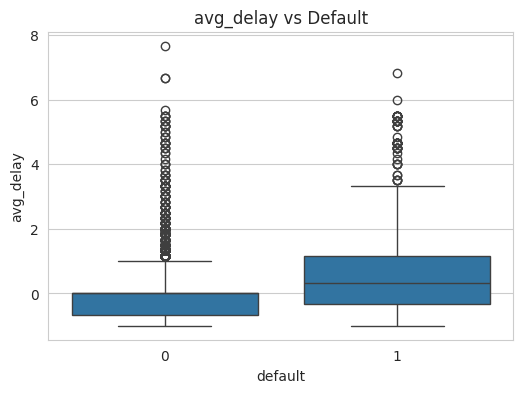

In [ ]:

# Example: distribution of avg_delay by default status
sns.boxplot(x='default', y='avg_delay', data=combined_df)
plt.title("avg_delay vs Default")
plt.show()


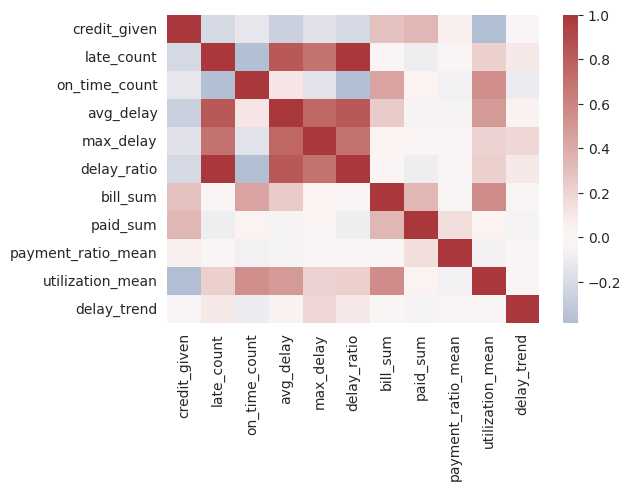

In [ ]:
corr = combined_df.drop(columns=['client_id','month','default',"gender","education","marital_status","marital_status_cat","gender_label","hist_count"]).corr()
sns.heatmap(corr, cmap='vlag', center=0)
plt.show()
